Спрогнозувати LTV за пів року життя користувача.

LTV потрібно спрогнозувати тільки для підписки tenwords_1w_9.99_offer. 

Рішення має містити:

- розбиття LTV на компоненти
- передбачення компонент на базі історичних даних. (Варто зазначити, що в цьому випадку не вимагається складних математичних моделей чи підходів ML)

Структура даних:

- refunded=True - гроші за транзакцію повернено;

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
transactions = pd.read_csv('input_files/file1_transactions.csv')
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

Для розрахунку LTV можна використати когортний аналіз, у нас є унікальні id користувачів і дані про дату оплати, тому далі ми зможемо розділити їх на когорти за датою першої оплати.

Фільтруємо дані для 'tenwords_1w_9.99_offer'

In [3]:
transactions = transactions[transactions['product_id'] == 'tenwords_1w_9.99_offer']
transactions.head()

,user_id,product_id,refunded,purchase_date,country_code,media_source
1,2604470,tenwords_1w_9.99_offer,False,2020-09-29,UK,Facebook Ads
2,2274467,tenwords_1w_9.99_offer,False,2020-08-18,Organic/Unknown,Organic/Unknown
4,2571294,tenwords_1w_9.99_offer,False,2020-09-25,US,Google Ads
5,2217390,tenwords_1w_9.99_offer,False,2020-09-05,MX,Facebook Ads
6,2086438,tenwords_1w_9.99_offer,False,2020-07-28,US,Facebook Ads


Підраховуємо доходи з одного користувача за пілписку в залежності від номера оплати за датою і чи було здійснено реффанд.

In [4]:
transactions = transactions.sort_values(by=['user_id', 'purchase_date'])
transactions['transaction_number'] = transactions.groupby('user_id').cumcount() + 1

def calculate_earnings(row):
    if row['refunded']:
        return 0
    if row['product_id'] == 'tenwords_1w_9.99_offer':
        return 0.5 if row['transaction_number'] == 1 else 9.99
    else:
        return 0

transactions['earnings'] = transactions.apply(calculate_earnings, axis=1)
transactions[transactions['earnings'] == 9.99]

,user_id,product_id,refunded,purchase_date,country_code,media_source,transaction_number,earnings
61235,31549,tenwords_1w_9.99_offer,False,2020-08-25,CO,Facebook Ads,2,9.99
46464,34491,tenwords_1w_9.99_offer,False,2020-07-22,Organic/Unknown,Organic/Unknown,2,9.99
57328,34491,tenwords_1w_9.99_offer,False,2020-08-22,Organic/Unknown,Organic/Unknown,3,9.99
62809,34491,tenwords_1w_9.99_offer,False,2020-08-22,Organic/Unknown,Organic/Unknown,4,9.99
60111,35450,tenwords_1w_9.99_offer,False,2020-08-20,KR,Facebook Ads,2,9.99
...,...,...,...,...,...,...,...,...
59475,2824561,tenwords_1w_9.99_offer,False,2020-08-23,Organic/Unknown,Organic/Unknown,2,9.99
15135,2824561,tenwords_1w_9.99_offer,False,2020-08-30,Organic/Unknown,Organic/Unknown,3,9.99
59323,2824561,tenwords_1w_9.99_offer,False,2020-08-30,Organic/Unknown,Organic/Unknown,4,9.99
17002,2824561,tenwords_1w_9.99_offer,False,2020-09-06,Organic/Unknown,Organic/Unknown,5,9.99


In [5]:
transactions_agg = transactions.copy().groupby(
    ['refunded']
).agg({'earnings': 'sum', 'user_id': 'count'}).reset_index()
transactions_agg

,refunded,earnings,user_id
0,False,251924.06,41799
1,True,0.00,1814


Знаходимо першу оплату для кожного користувача та додаємо колонку з когортою (перший день оплати), до якої буде належати користувач.

In [6]:
transactions['cohort_date'] = transactions.groupby('user_id')['purchase_date'].transform('min')

Обчислюємо щоденний дохід для кожної дати кожної когорти.

In [7]:
cohort_revenue = transactions.copy().groupby(
    ['cohort_date', 'purchase_date']
).agg({'earnings': 'sum'}).reset_index()

cohort_revenue.head()

,cohort_date,purchase_date,earnings
0,2020-07-01,2020-07-01,146.91
1,2020-07-01,2020-07-08,469.53
2,2020-07-01,2020-07-15,289.71
3,2020-07-01,2020-07-22,199.80
4,2020-07-01,2020-07-29,169.83


Розрахуємо кумулятивний дохід для кожної когорти.

In [8]:
cumulative_revenue_df = cohort_revenue.copy().groupby('cohort_date').apply(
    lambda x: x.assign(cumulative_revenue=x['earnings'].cumsum())
).reset_index(drop=True)

cumulative_revenue_df.head()

,cohort_date,purchase_date,earnings,cumulative_revenue
0,2020-07-01,2020-07-01,146.91,146.91
1,2020-07-01,2020-07-08,469.53,616.44
2,2020-07-01,2020-07-15,289.71,906.15
3,2020-07-01,2020-07-22,199.80,1105.95
4,2020-07-01,2020-07-29,169.83,1275.78


Кількість нових користувачів у кожній когорті.

In [9]:
cohort_sizes = transactions.copy().groupby('cohort_date')['user_id'].nunique().reset_index()
cohort_sizes.head()

,cohort_date,user_id
0,2020-07-01,118
1,2020-07-02,125
2,2020-07-03,129
3,2020-07-04,125
4,2020-07-05,142


Об'єднуємо дані кожної когорти з їх кількістю користувачів.

In [10]:
cumulative_arpu_df = cumulative_revenue_df.copy().merge(cohort_sizes, on='cohort_date')
cumulative_arpu_df = cumulative_arpu_df.rename(columns={'user_id': 'cohort_size'})
cumulative_arpu_df.head()

,cohort_date,purchase_date,earnings,cumulative_revenue,cohort_size
0,2020-07-01,2020-07-01,146.91,146.91,118
1,2020-07-01,2020-07-08,469.53,616.44,118
2,2020-07-01,2020-07-15,289.71,906.15,118
3,2020-07-01,2020-07-22,199.80,1105.95,118
4,2020-07-01,2020-07-29,169.83,1275.78,118


Обчислюємо кумулятивний ARPU за формулою:

загальний дохід за період / кіль-ть користувачів за період

In [11]:
cumulative_arpu_df['cumulative_arpu'] = cumulative_arpu_df['cumulative_revenue'] / cumulative_arpu_df['cohort_size']

cumulative_arpu_df.head()

,cohort_date,purchase_date,earnings,cumulative_revenue,cohort_size,cumulative_arpu
0,2020-07-01,2020-07-01,146.91,146.91,118,1.245000
1,2020-07-01,2020-07-08,469.53,616.44,118,5.224068
2,2020-07-01,2020-07-15,289.71,906.15,118,7.679237
3,2020-07-01,2020-07-22,199.80,1105.95,118,9.372458
4,2020-07-01,2020-07-29,169.83,1275.78,118,10.811695


Для побудови хіт мапи ARPU для когорт, перетворимо дані у зведену таблицю.

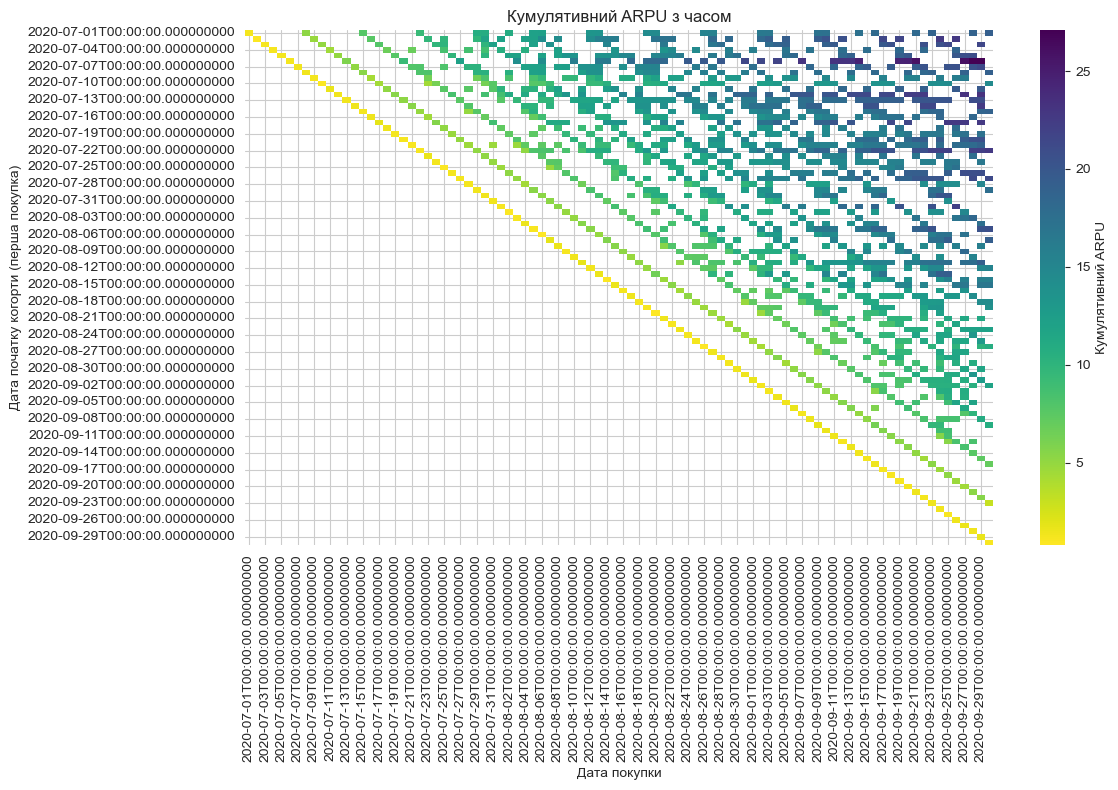

In [12]:
arpu_pivot = cumulative_arpu_df.pivot_table(
    index='cohort_date',
    columns='purchase_date',
    values='cumulative_arpu',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(arpu_pivot, annot=False, cmap='viridis_r', cbar_kws={'label': 'Кумулятивний ARPU'})
plt.title("Кумулятивний ARPU з часом")
plt.xlabel("Дата покупки")
plt.ylabel("Дата початку когорти (перша покупка)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

На хіт мапі можна чітко розпізнати користувачів, які поновлюють підписку кожного тижня, але чим більше часу проходить з першої транзакції, тим більшим є розкид користувачів за датами транзакції в одній і тій самій когорті. Також, аналізуючи час з першого дня кожної з когорт, великих змін у поведінці все новіших користувачів у порівнянні зі старими не спостерігається.

Обраховуємо lifetime для кожної когорти. Шукаємо різницю між 1 і останньою транзакцією, так як перший день користувача також є його lifetime, то додаємо 1. Для кожної когорти шукаємо середнє значення.

In [13]:
transactions['last_purchase_date'] = transactions.groupby('user_id')['purchase_date'].transform('max')

transactions['lifetime'] = (transactions['last_purchase_date'] - transactions['cohort_date']).dt.days + 1

lifetime_by_cohort = transactions.groupby('cohort_date')['lifetime'].mean().reset_index()
lifetime_by_cohort.head()

,cohort_date,lifetime
0,2020-07-01,44.692754
1,2020-07-02,48.459459
2,2020-07-03,46.760391
3,2020-07-04,42.267956
4,2020-07-05,46.230068


Групуємо дані по днях і обчислюємо середній ARPU за 1 день.

In [14]:
daily_arpu = cumulative_arpu_df.groupby('purchase_date').agg(
    cumulative_arpu=('cumulative_arpu', 'mean') 
).reset_index()
daily_arpu.head()

,purchase_date,cumulative_arpu
0,2020-07-01,1.245000
1,2020-07-02,0.895600
2,2020-07-03,1.193101
3,2020-07-04,1.131360
4,2020-07-05,1.270352


Тепер можемо зобразити зміну ARPU за днями на графіку.

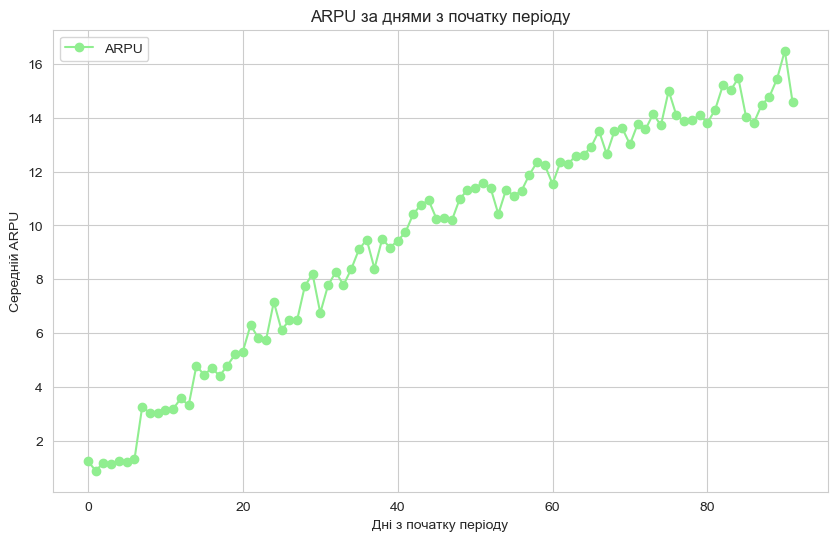

In [15]:
daily_arpu['days_since_start'] = (daily_arpu['purchase_date'] - daily_arpu['purchase_date'].min()).dt.days

plt.figure(figsize=(10, 6))
plt.plot(daily_arpu['days_since_start'], daily_arpu['cumulative_arpu'], marker='o', color='lightgreen', label='ARPU')
plt.title('ARPU за днями з початку періоду')
plt.xlabel('Дні з початку періоду')
plt.ylabel('Середній ARPU')
plt.legend()
plt.grid(True)
plt.show()

Висунемо припущення, що це логарифмічна крива, отже спрогнозуємо ARPU за логарифмом. Підбираємо параметри за допомогою curve_fit().

In [16]:
def log_model(x, a, b):
    return a * np.log(x) + b

filtered_data = daily_arpu[daily_arpu['days_since_start'] > 0]

X = filtered_data['days_since_start'].values
y = filtered_data['cumulative_arpu'].values

params, _ = curve_fit(log_model, X, y)

Виконуємо прогноз для початкового періоду і ще на 3 місяці, щоб охопити шестимісячний період.

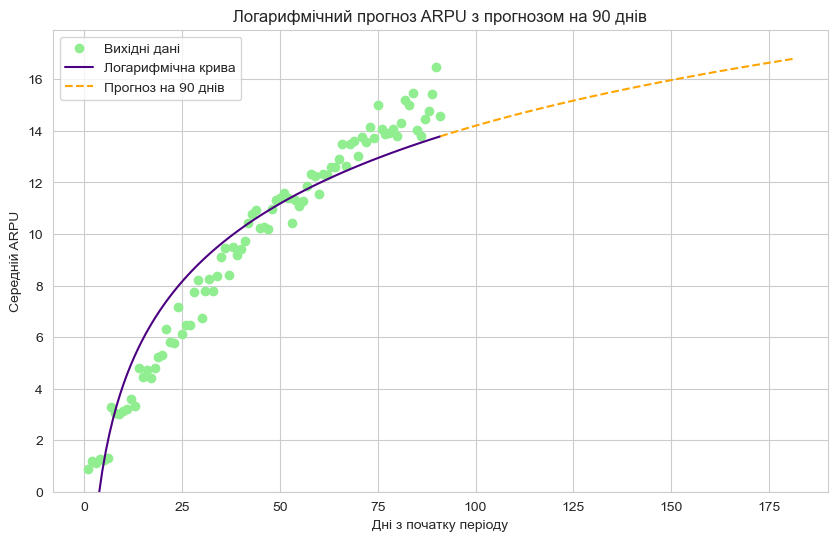

Параметри моделі: a = 4.37, b = -5.91


In [17]:
X_pred = np.linspace(min(X), max(X), 100) 
y_pred = log_model(X_pred, *params)

X_pred_future = np.linspace(max(X), max(X) + 90, 90)
y_pred_future = log_model(X_pred_future, *params)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='lightgreen', label='Вихідні дані')
plt.plot(X_pred, y_pred, color='indigo', label='Логарифмічна крива')
plt.plot(X_pred_future, y_pred_future, color='orange', linestyle='--', label='Прогноз на 90 днів')
plt.title('Логарифмічний прогноз ARPU з прогнозом на 90 днів')
plt.xlabel('Дні з початку періоду')
plt.ylabel('Середній ARPU')
plt.ylim(0,)
plt.legend()
plt.grid(True)
plt.show()

a, b = params
print(f"Параметри моделі: a = {a:.2f}, b = {b:.2f}")

Для ARPU логарифмічна крива є досить вдалим вибором, хоч і існує певна похибка. Як було сказано раніше, користувачі були передбачуваними протягом усіх когорт, тому бачимо невеликий розкид даних і відсутність аномалій.

In [18]:
print(f'Передбачене ARPU за 6 місяців життя користувача: {y_pred_future[-1]}')

Передбачене ARPU за 6 місяців життя користувача: 16.791803960678045
